# Imports

In [1]:
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import os
import csv
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import soundfile as sf


2025-04-30 20:45:17.491870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

In [2]:
# Loading Dataset and Built Character to Index and Index to Character Mappings
dataset_dir = '/Users/trystanwillard/Downloads/archive/common_words/common_words/output'  
char_set = "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
char_to_index = {char: i+1 for i, char in enumerate(char_set)}
index_to_char = {i: char for char, i in char_to_index.items()}

target_seq_length = 50

# Audio Feature Extraction

In [3]:
# Loading Audio Files and Extracting Features using Mel-Frequency Cepstral Coefficients (MFCC)
def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr)
    return audio, sr

def extract_mfcc(audio, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

def pad_features(features, max_len):
    return pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')[0]

def encode_text(text, max_len):
    encoded = [char_to_index[char.upper()] for char in text if char.upper() in char_to_index]
    return pad_sequences([encoded], maxlen=max_len, padding='post')[0]


# Split Audio Files Into Individual Words

In [4]:
# Function That Splits Audio File into Individual words and Creates Individual .WAV Files and Imports Them to a CSV File
def split_audio_into_words(input_file, output_dir, words, wpm=12):
    
    import os
    os.makedirs(output_dir, exist_ok=True) 
    
    audio, sr = librosa.load(input_file, sr=None)
    
    total_duration = librosa.get_duration(y=audio, sr=sr)
    word_duration = total_duration / len(words)  
    
    # Prepares and Writes to CSV file
    csv_filename = os.path.join(output_dir, 'words_mapping.csv')
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["filename", "label"]) 

        for idx, word in enumerate(words):
            start_time = idx * word_duration
            end_time = start_time + word_duration
            word_audio = audio[int(start_time * sr):int(end_time * sr)]
            
            word_filename = os.path.join(output_dir, f"{word}.wav")
            sf.write(word_filename, word_audio, sr)
            
            writer.writerow([f"{word}.wav", word])
    
    print(f"Audio files split and saved in {output_dir}, CSV file created.")

# Audio File Local Import Directories
input_audio_file = '/Users/trystanwillard/Downloads/archive/common_words/common_words/100MostCommonEnglishWords12.wav' 
output_directory = '/Users/trystanwillard/Downloads/archive/common_words/common_words/output' 
txt_file_path = '/Users/trystanwillard/Downloads/archive/common_words/common_words/100-common-words.txt'  

with open(txt_file_path, 'r') as f:
    content = f.read()
    words_list = content.strip().split()

split_audio_into_words(input_audio_file, output_directory, words_list, wpm=12)

Audio files split and saved in /Users/trystanwillard/Downloads/archive/common_words/common_words/output, CSV file created.


# Dataset Build

In [5]:
# Build Dataset Utility Function
def dataset_build(audio_dir, max_audio_len=200):
    X, Y = [], []
    for file_name in os.listdir(audio_dir):
        if not file_name.endswith('mp3') and not file_name.endswith('.wav'):
            continue
        file_path = os.path.join(audio_dir, file_name)
        label_text = os.path.splitext(file_name)[0].replace('_', ' ')
        
        audio, sr = load_audio(file_path)
        mfcc = extract_mfcc(audio, sr)
        mfcc_padded = pad_features(mfcc, max_audio_len)
        label_encoded = encode_text(label_text, target_seq_length)
        
        X.append(mfcc_padded)
        Y.append(label_encoded)
    return np.array(X), np.array(Y)

# Load and Split Data

In [6]:
# Loads Dataset
X, Y = dataset_build(dataset_dir, max_audio_len=200)

# Splits Data and Creates Training and Validation Sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]
output_vocab_size = len(char_to_index)


# RNN Model

In [365]:
# Builds and Compiles RNN Model - Performs Truncating to Match Target Sequence Length
def rnn_model_build(input_shape, output_vocab_size, target_seq_length):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.SimpleRNN(128, return_sequences=True),
        layers.SimpleRNN(128, return_sequences=True),
        layers.Dense(output_vocab_size + 1, activation='softmax'),
        layers.Lambda(lambda x: x[:, :target_seq_length]) 
    ])
    return model

rnn_model = rnn_model_build(input_shape, output_vocab_size, target_seq_length)
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_46 (SimpleRNN)       │ (None, 200, 128)       │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_47 (SimpleRNN)       │ (None, 200, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 200, 37)        │         4,773 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_82 (Lambda)              │ (None, 50, 37)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,845 (218.14 KB)

 Trainable params: 55,845 (218.14 KB)

 Non-trainable params: 0 (0.00 B)

# LSTM Model

In [366]:
# Builds and Compiles LSTM Model - Performs Truncating to Match Target Sequence Length
def lstm_model_build(input_shape, output_vocab_size):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.TimeDistributed(layers.Dense(output_vocab_size + 1, activation='softmax')),
        layers.Lambda(lambda x: x[:, :50, :])
    ])
    return model

lstm_model = lstm_model_build(input_shape, output_vocab_size)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_46                │ (None, 200, 256)       │       145,408 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 200, 256)       │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 200, 37)        │         9,509 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_83 (Lambda)              │ (None, 50, 37)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,157 (2.09 MB)

 Trainable params: 549,157 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

# Transformer Encoder and Model

In [367]:
# Builds and Compiles Transformer Model - Includes Attention and Feedforward Network Layers

# Transformer Encoder Block
def transformer_encode_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn = layers.Dropout(rate)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn)
    
    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(embed_dim)(ffn)
    ffn = layers.Dropout(rate)(ffn)
    outputs = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    
    return models.Model(inputs, outputs)

# Builds Transformer Model
def transformer_model_build(input_shape, output_vocab_size):
    inputs = layers.Input(shape=input_shape)
  
    x = transformer_encode_block(embed_dim=input_shape[-1], num_heads=4, ff_dim=256)(inputs)
    
    x = transformer_encode_block(embed_dim=input_shape[-1], num_heads=4, ff_dim=256)(x)
   
    x = layers.Lambda(lambda t: t[:, :50, :])(x)
    
    x = layers.Dense(output_vocab_size + 1, activation='softmax')(x)
    
    return models.Model(inputs, x)

# Initializes and Compiles the Model
transformer_model = transformer_model_build(input_shape, output_vocab_size)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

transformer_model.summary()

Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_137 (InputLayer)    │ (None, 200, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_137 (Functional)     │ (None, 200, 13)        │         9,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_138 (Functional)     │ (None, 200, 13)        │         9,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_84 (Lambda)              │ (None, 50, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 50, 37)         │           518 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,218 (78.98 KB)

 Trainable params: 20,218 (78.98 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [368]:
# Model Training Function - Hyperparameter Configuration
BATCH_SIZE = 16
EPOCHS = 30

def train_model(model, name):
    checkpoint_cb = callbacks.ModelCheckpoint(f'{name}_best_model.h5', save_best_only=True, monitor='val_loss')
    earlystop_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, Y_train,
        validation_data = (X_val, Y_val),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks=[checkpoint_cb, earlystop_cb]
    )
    return history

# RNN Model Training 

In [369]:
# Train RNN Model
history_rnn = train_model(rnn_model, "rnn_model")

Epoch 1/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2678 - loss: 3.4077

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.3531 - loss: 3.0821 - val_accuracy: 0.9371 - val_loss: 0.4171
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9306 - loss: 0.4572 - val_accuracy: 0.9371 - val_loss: 0.4632
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9310 - loss: 0.4986 - val_accuracy: 0.9371 - val_loss: 0.4535
Epoch 4/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9300 - loss: 0.4839

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9303 - loss: 0.4796 - val_accuracy: 0.9381 - val_loss: 0.4124
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9331 - loss: 0.4136

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9329 - loss: 0.4145 - val_accuracy: 0.9381 - val_loss: 0.3870
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9319 - loss: 0.3973

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9319 - loss: 0.3974 - val_accuracy: 0.9381 - val_loss: 0.3818
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9318 - loss: 0.3850

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9318 - loss: 0.3852 - val_accuracy: 0.9381 - val_loss: 0.3706
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9325 - loss: 0.3749

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9326 - loss: 0.3748 - val_accuracy: 0.9381 - val_loss: 0.3547
Epoch 9/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9327 - loss: 0.3678

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9329 - loss: 0.3652 - val_accuracy: 0.9381 - val_loss: 0.3388
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9357 - loss: 0.3319

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9354 - loss: 0.3335 - val_accuracy: 0.9400 - val_loss: 0.3251
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9352 - loss: 0.3242

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9350 - loss: 0.3247 - val_accuracy: 0.9400 - val_loss: 0.3128
Epoch 12/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9318 - loss: 0.3307

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9326 - loss: 0.3259 - val_accuracy: 0.9400 - val_loss: 0.2991
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9360 - loss: 0.2951

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9358 - loss: 0.2958 - val_accuracy: 0.9400 - val_loss: 0.2862
Epoch 14/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9354 - loss: 0.2827

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9350 - loss: 0.2838 - val_accuracy: 0.9400 - val_loss: 0.2741
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9377 - loss: 0.2646

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9372 - loss: 0.2661 - val_accuracy: 0.9390 - val_loss: 0.2647
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9346 - loss: 0.2675

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9346 - loss: 0.2670 - val_accuracy: 0.9390 - val_loss: 0.2599
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9351 - loss: 0.2563

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9349 - loss: 0.2564 - val_accuracy: 0.9390 - val_loss: 0.2526
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9344 - loss: 0.2446

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9343 - loss: 0.2452 - val_accuracy: 0.9390 - val_loss: 0.2482
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9358 - loss: 0.2405

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9358 - loss: 0.2409 - val_accuracy: 0.9390 - val_loss: 0.2481
Epoch 20/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9373 - loss: 0.2368

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9372 - loss: 0.2370 - val_accuracy: 0.9390 - val_loss: 0.2407
Epoch 21/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9367 - loss: 0.2356

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9369 - loss: 0.2351 - val_accuracy: 0.9400 - val_loss: 0.2393
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.2239

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9400 - loss: 0.2249 - val_accuracy: 0.9400 - val_loss: 0.2367
Epoch 23/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9378 - loss: 0.2275

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9378 - loss: 0.2278 - val_accuracy: 0.9400 - val_loss: 0.2356
Epoch 24/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9366 - loss: 0.2322

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9371 - loss: 0.2304 - val_accuracy: 0.9410 - val_loss: 0.2355
Epoch 25/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9395 - loss: 0.2230 - val_accuracy: 0.9410 - val_loss: 0.2386
Epoch 26/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9402 - loss: 0.2164 - val_accuracy: 0.9400 - val_loss: 0.2383
Epoch 27/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9411 - loss: 0.2158

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9407 - loss: 0.2168 - val_accuracy: 0.9419 - val_loss: 0.2338
Epoch 28/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9397 - loss: 0.2186 - val_accuracy: 0.9419 - val_loss: 0.2397
Epoch 29/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9387 - loss: 0.2278

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9389 - loss: 0.2259 - val_accuracy: 0.9419 - val_loss: 0.2328
Epoch 30/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9413 - loss: 0.2120

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9407 - loss: 0.2143 - val_accuracy: 0.9429 - val_loss: 0.2313


# LSTM Model Training

In [370]:
# Train LSTM Model
history_lstm = train_model(lstm_model, "lstm_model")

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7904 - loss: 1.7976

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 871ms/step - accuracy: 0.8008 - loss: 1.7126 - val_accuracy: 0.9371 - val_loss: 0.3818
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.9298 - loss: 0.4428 - val_accuracy: 0.9371 - val_loss: 0.3846
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9302 - loss: 0.4240

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.9303 - loss: 0.4217 - val_accuracy: 0.9371 - val_loss: 0.3192
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9292 - loss: 0.3592

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.9295 - loss: 0.3562 - val_accuracy: 0.9371 - val_loss: 0.2890
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9314 - loss: 0.3117

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.9316 - loss: 0.3114 - val_accuracy: 0.9390 - val_loss: 0.2734
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9325 - loss: 0.2965

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.9327 - loss: 0.2955 - val_accuracy: 0.9390 - val_loss: 0.2607
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9339 - loss: 0.2749

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9339 - loss: 0.2748 - val_accuracy: 0.9390 - val_loss: 0.2505
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9352 - loss: 0.2584

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - accuracy: 0.9350 - loss: 0.2589 - val_accuracy: 0.9390 - val_loss: 0.2445
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9312 - loss: 0.2657

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.9315 - loss: 0.2642 - val_accuracy: 0.9390 - val_loss: 0.2371
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9350 - loss: 0.2491

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.9349 - loss: 0.2491 - val_accuracy: 0.9381 - val_loss: 0.2322
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9328 - loss: 0.2465 - val_accuracy: 0.9390 - val_loss: 0.2324
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9325 - loss: 0.2449

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.9327 - loss: 0.2439 - val_accuracy: 0.9400 - val_loss: 0.2306
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9342 - loss: 0.2307

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.9342 - loss: 0.2312 - val_accuracy: 0.9419 - val_loss: 0.2284
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.9340 - loss: 0.2359 - val_accuracy: 0.9419 - val_loss: 0.2345
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.9366 - loss: 0.2292 - val_accuracy: 0.9429 - val_loss: 0.2287
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9402 - loss: 0.2188

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - accuracy: 0.9397 - loss: 0.2203 - val_accuracy: 0.9429 - val_loss: 0.2281
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.9393 - loss: 0.2174 - val_accuracy: 0.9410 - val_loss: 0.2345
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9373 - loss: 0.2213

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.9373 - loss: 0.2214 - val_accuracy: 0.9448 - val_loss: 0.2224
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.9374 - loss: 0.2186 - val_accuracy: 0.9438 - val_loss: 0.2285
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.9380 - loss: 0.2195 - val_accuracy: 0.9429 - val_loss: 0.2267
Epoch 21/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.9392 - loss: 0.2158 - val_accuracy: 0.9429 - val_loss: 0.2256
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.9372 - loss: 0.2135 - val_accuracy: 0.9429 - val_loss: 0.2296
Epoch 23/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.9399 - loss: 0.2090 - val_accuracy: 0.9438 - val_loss: 0.2282


# Transformer Model Training

In [371]:
# Train Transformer Model
history_transformer = train_model(transformer_model, "transformer_model")

Epoch 1/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0000e+00 - loss: 4.6660

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.0000e+00 - loss: 4.5668 - val_accuracy: 0.0019 - val_loss: 3.0808
Epoch 2/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2628 - loss: 2.9124

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3392 - loss: 2.8552 - val_accuracy: 0.9371 - val_loss: 2.0678
Epoch 3/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9317 - loss: 2.0404

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9315 - loss: 2.0155 - val_accuracy: 0.9371 - val_loss: 1.6354
Epoch 4/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9304 - loss: 1.6705

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9306 - loss: 1.6618 - val_accuracy: 0.9371 - val_loss: 1.4644
Epoch 5/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9319 - loss: 1.5186

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9316 - loss: 1.5137 - val_accuracy: 0.9371 - val_loss: 1.3525
Epoch 6/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9312 - loss: 1.4114

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9311 - loss: 1.4056 - val_accuracy: 0.9371 - val_loss: 1.2449
Epoch 7/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9325 - loss: 1.2947

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9321 - loss: 1.2908 - val_accuracy: 0.9371 - val_loss: 1.1426
Epoch 8/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9301 - loss: 1.2002

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9304 - loss: 1.1939 - val_accuracy: 0.9371 - val_loss: 1.0490
Epoch 9/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9270 - loss: 1.1174

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9281 - loss: 1.1081 - val_accuracy: 0.9371 - val_loss: 0.9668
Epoch 10/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9282 - loss: 1.0273

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9290 - loss: 1.0206 - val_accuracy: 0.9371 - val_loss: 0.8935
Epoch 11/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9285 - loss: 0.9510

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9292 - loss: 0.9446 - val_accuracy: 0.9371 - val_loss: 0.8280
Epoch 12/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9305 - loss: 0.8771

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9306 - loss: 0.8739 - val_accuracy: 0.9371 - val_loss: 0.7712
Epoch 13/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9285 - loss: 0.8263

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9292 - loss: 0.8213 - val_accuracy: 0.9371 - val_loss: 0.7227
Epoch 14/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9296 - loss: 0.7756

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9300 - loss: 0.7716 - val_accuracy: 0.9371 - val_loss: 0.6817
Epoch 15/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9292 - loss: 0.7346

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9297 - loss: 0.7307 - val_accuracy: 0.9371 - val_loss: 0.6467
Epoch 16/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9324 - loss: 0.6855

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9320 - loss: 0.6854 - val_accuracy: 0.9371 - val_loss: 0.6170
Epoch 17/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9304 - loss: 0.6652

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9306 - loss: 0.6625 - val_accuracy: 0.9371 - val_loss: 0.5923
Epoch 18/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9291 - loss: 0.6422

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9297 - loss: 0.6387 - val_accuracy: 0.9371 - val_loss: 0.5713
Epoch 19/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9296 - loss: 0.6184

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9300 - loss: 0.6157 - val_accuracy: 0.9371 - val_loss: 0.5533
Epoch 20/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9307 - loss: 0.5943

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9308 - loss: 0.5930 - val_accuracy: 0.9371 - val_loss: 0.5378
Epoch 21/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9311 - loss: 0.5755

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9311 - loss: 0.5750 - val_accuracy: 0.9371 - val_loss: 0.5244
Epoch 22/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9353 - loss: 0.5406

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9341 - loss: 0.5466 - val_accuracy: 0.9371 - val_loss: 0.5130
Epoch 23/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9286 - loss: 0.5641

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9293 - loss: 0.5598 - val_accuracy: 0.9371 - val_loss: 0.5024
Epoch 24/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9287 - loss: 0.5545

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9294 - loss: 0.5498 - val_accuracy: 0.9371 - val_loss: 0.4913
Epoch 25/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9300 - loss: 0.5365

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9302 - loss: 0.5344 - val_accuracy: 0.9371 - val_loss: 0.4791
Epoch 26/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9341 - loss: 0.5040

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9332 - loss: 0.5076 - val_accuracy: 0.9371 - val_loss: 0.4630
Epoch 27/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9307 - loss: 0.5073

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9308 - loss: 0.5067 - val_accuracy: 0.9371 - val_loss: 0.4457
Epoch 28/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9332 - loss: 0.4853

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9326 - loss: 0.4880 - val_accuracy: 0.9371 - val_loss: 0.4340
Epoch 29/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9337 - loss: 0.4698

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9329 - loss: 0.4734 - val_accuracy: 0.9381 - val_loss: 0.4269
Epoch 30/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9336 - loss: 0.4658

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9328 - loss: 0.4684 - val_accuracy: 0.9381 - val_loss: 0.4215


# Plotting Training History

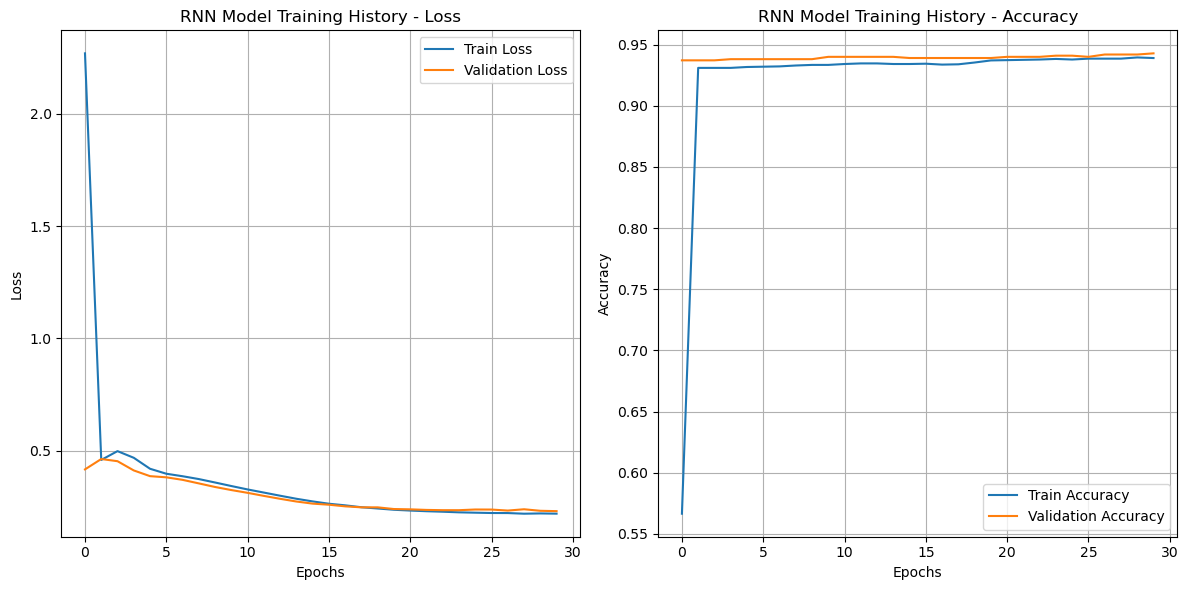

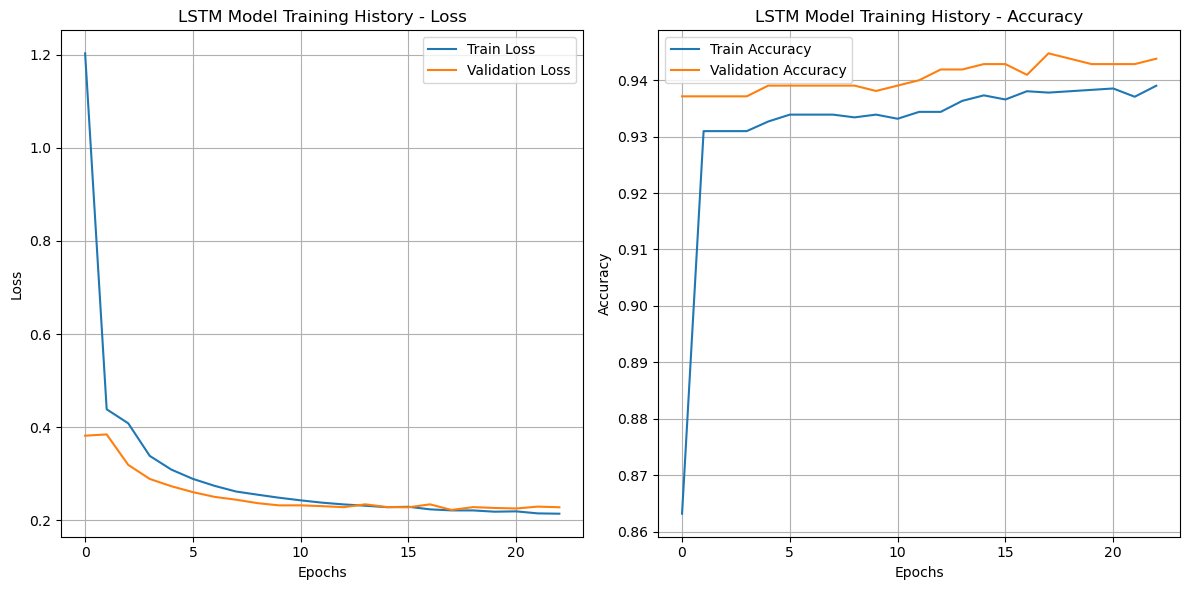

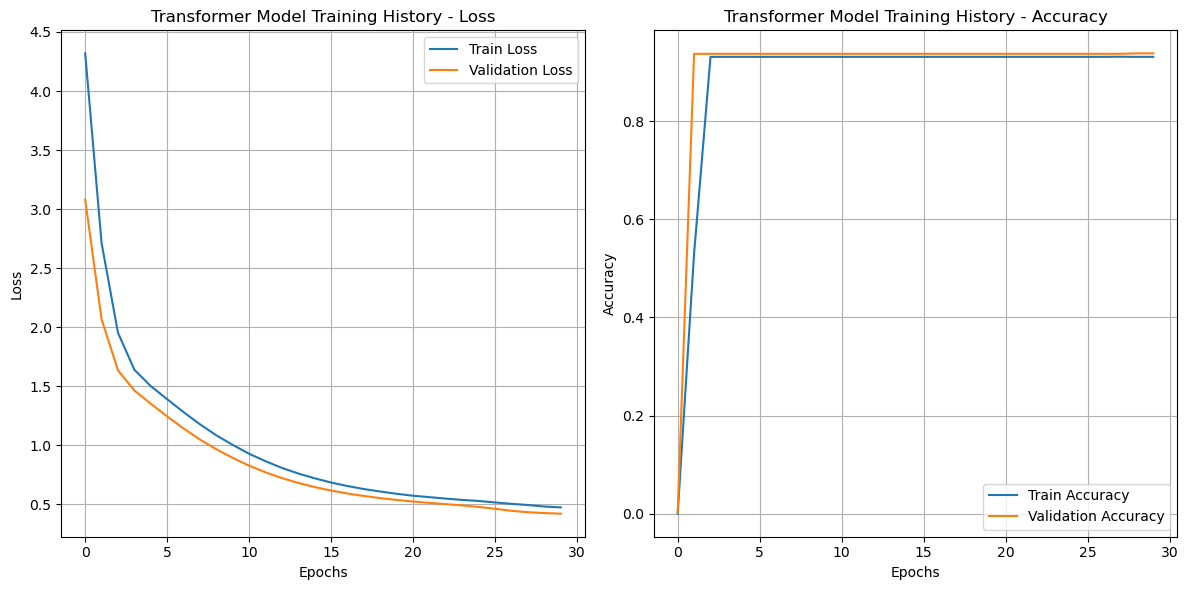

In [372]:
# Displays RNN, LSTM, Transformer Accuracy and Loss Plots 
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history_rnn, "RNN Model Training History")
plot_history(history_lstm, "LSTM Model Training History")
plot_history(history_transformer, "Transformer Model Training History")

# Decode Output

In [373]:
# Decodes Predictions
def decode_prediction(pred, index_to_char):
    pred_indices = np.argmax(pred, axis=-1)  
    decoded = ''.join(index_to_char.get(idx, '') for idx in pred_indices if idx > 0)
    return decoded

sample_index = 0
sample_input = np.expand_dims(X_val[sample_index], axis=0)
sample_true = Y_val[sample_index]

# RNN Prediction Output
pred_output = rnn_model.predict(sample_input)
decoded_rnn = decode_prediction(pred_output[0], index_to_char)  
true_label = decode_prediction(np.expand_dims(sample_true, axis=0), index_to_char)

print(f"RNN Predicted: {decoded_rnn}")

# LSTM Prediction Output
pred_output_lstm = lstm_model.predict(sample_input)
decoded_lstm = decode_prediction(pred_output_lstm[0], index_to_char)
print(f"LSTM Predicted: {decoded_lstm}")

# Transformer Prediction Output
pred_output_transformer = transformer_model.predict(sample_input)
decoded_transformer = decode_prediction(pred_output_transformer[0], index_to_char)
print(f"Transformer Predicted: {decoded_transformer}") 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
RNN Predicted: TO
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
LSTM Predicted: THE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Transformer Predicted: Y
